In [1]:
import jax
import jax.numpy as jnp
import pandas as pd
import optax

import tensorflow_probability.substrates.jax as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

import matplotlib.pyplot as plt
from tqdm import trange

from laplax import ADLaplace
from laplax.utils import train_model
import distrax

In [2]:
def get_likelihood(params, aux):
    loc = params['w1'] * aux['x'] + params['w2']
    scale = 1.0
    return tfd.Normal(loc, scale)

def prepare_model(config_name, bijector):
    config = pd.read_pickle(f'../data/linear_regression/{config_name}')
    data = config['data']
    aux = {'x': data['x'].ravel()}
    y = data['y']
    prior_loc = config['prior']['mean']
    prior_scale = jnp.diag(config['prior']['var'])**0.5
    
    prior = {'w1': tfd.Normal(loc=prior_loc[0], scale=prior_scale[0]), 
            "w2": tfd.Normal(loc=prior_loc[1], scale=prior_scale[1])}
    bijectors = {'w1': bijector, "w2": bijector}
    
    return ADLaplace(prior, bijectors, get_likelihood), y, aux

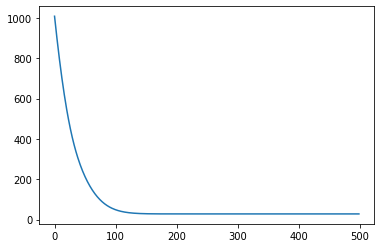

In [3]:
config_name = "linear_regression"
model, data, aux = prepare_model(config_name=config_name, bijector=tfb.Identity())

optimizer = optax.adam(learning_rate=0.1)
n_epochs = 500
seed = jax.random.PRNGKey(1)

params, losses = train_model(model, data, aux, optimizer, n_epochs, seed)

plt.plot(losses);

posterior = model.apply(params, data, aux)

pd.to_pickle(
    {"params": params, "model": model, "data": data, "aux": aux},
    f"../results/linear_regression/results_data/laplax_{config_name}",
    protocol=1,
)

In [4]:
params

{'w1': DeviceArray(2.238753, dtype=float32),
 'w2': DeviceArray(3.7154002, dtype=float32)}